<a href="https://colab.research.google.com/github/sainiketh372/Retinal_Disease_Analysis_using_U-Net_Architecture/blob/main/Retinal_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install tensorflow-gpu(Not needed)
#!pip install tensorflow

#This model is based upon U-Net(for segementation)
# Blue Line graphs = Expected value
# Red Line graphs = obtained values from model
#IOU= Intersection of union

In [ ]:
# import tensorflow as tf
# tf.test.is_gpu_available()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Pat_project/Sourcecode1')
!ls

dataset  Maincode.ipynb  modelOrgan1.h5  modelOrgandc.h5  modelOrgan.h5


In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
# %matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

In [ ]:
from tensorflow.keras.layers import concatenate,add
from tensorflow.keras.preprocessing.image import img_to_array



In [ ]:

from tensorflow import keras
from keras.models import Model, load_model
from keras.layers import LeakyReLU
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D,GlobalMaxPool2D

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import tensorflow as tf
from keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from keras.models import model_from_json

In [ ]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS=1
leaky_relu_alpha = 0.01
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

ids = next(os.walk("/content/drive/MyDrive/Pat_project/Sourcecode1/dataset/train/image"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

ids1 = next(os.walk("/content/drive/MyDrive/Pat_project/Sourcecode1/dataset/train/mask"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  20
No. of images =  20


In [ ]:
X = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)
y = np.zeros((len(ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("/content/drive/MyDrive/Pat_project/Sourcecode1/dataset/train/image/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img("/content/drive/MyDrive/Pat_project/Sourcecode1/dataset/train/mask/"+id_, grayscale=True))
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

X.shape


<ipython-input-17-81711e7add50>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


(20, 128, 128, 1)

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5,shuffle=True , random_state=None)

for train_index, test_index in kf.split(X):
      print("Train:", train_index, "Validation:",test_index)
      X_train, X_valid = X[train_index], X[test_index]
      y_train, y_valid = y[train_index], y[test_index]

Train: [ 1  2  3  4  6  7  8  9 10 11 12 13 15 16 17 19] Validation: [ 0  5 14 18]
Train: [ 0  1  3  5  6  7  8  9 10 11 12 13 14 16 17 18] Validation: [ 2  4 15 19]
Train: [ 0  1  2  3  4  5  6  7  9 10 13 14 15 17 18 19] Validation: [ 8 11 12 16]
Train: [ 0  1  2  4  5  6  7  8 11 12 14 15 16 17 18 19] Validation: [ 3  9 10 13]
Train: [ 0  2  3  4  5  8  9 10 11 12 13 14 15 16 18 19] Validation: [ 1  6  7 17]


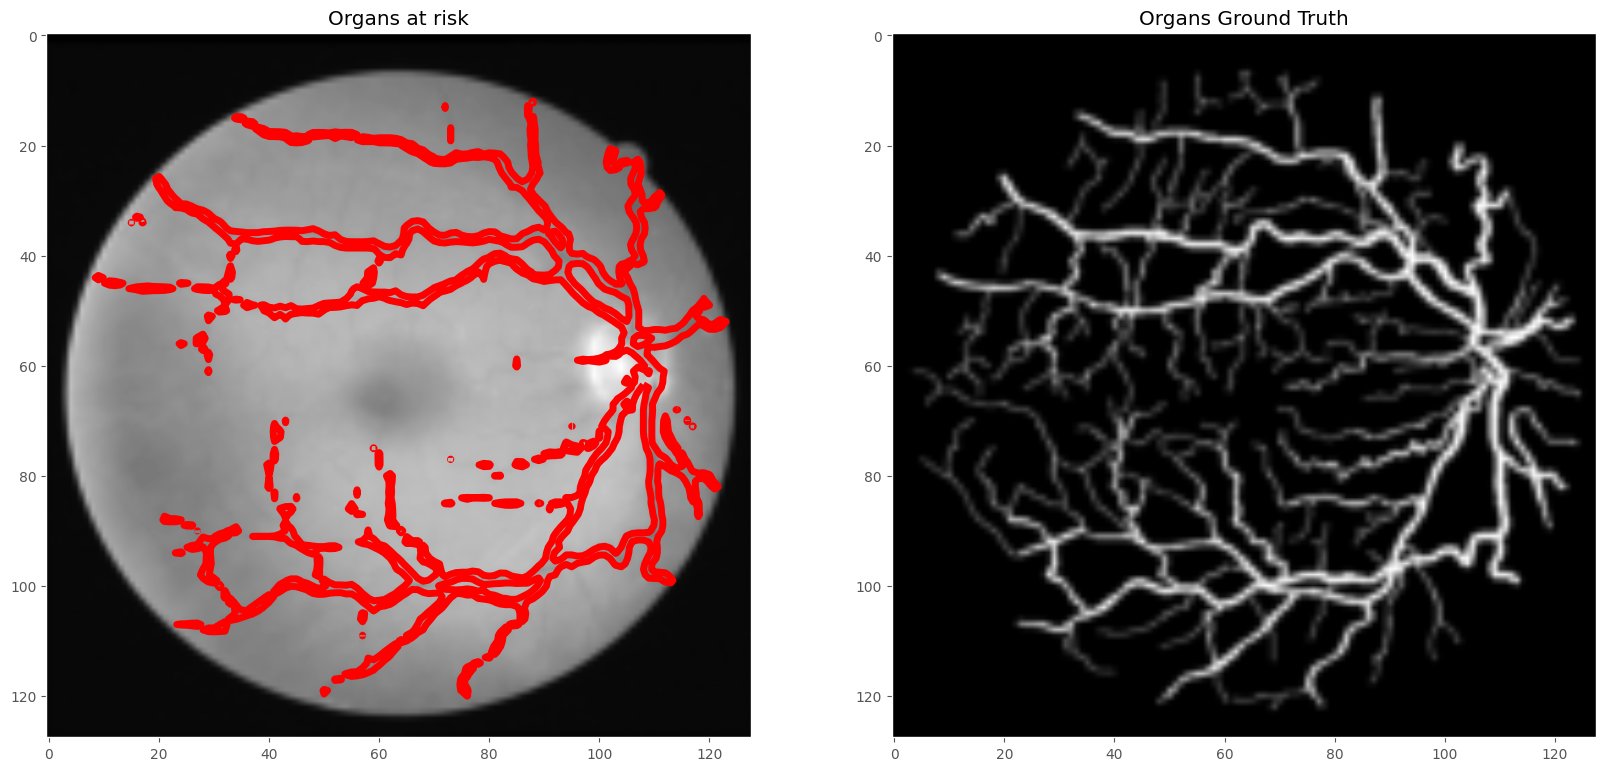

In [ ]:
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # organ mask

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'gray', interpolation = 'bilinear')
if has_mask: # if organ present
    # draw a boundary(contour) in the original image separating normal organs and organs at risk
    ax1.contour(y_train[ix].squeeze(), colors = 'Red', linewidths = 5, levels = [0.5])
ax1.set_title('Organs at risk')
ax1.grid(None)

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Organs Ground Truth')
ax2.grid(None)

In [ ]:
c1 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same') (s)
LeakyReLU(alpha=leaky_relu_alpha)(c1)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same') (c1)
LeakyReLU(alpha=leaky_relu_alpha)(c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same') (p1)
LeakyReLU(alpha=leaky_relu_alpha)(c2)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same') (c2)
LeakyReLU(alpha=leaky_relu_alpha)(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same') (p2)
LeakyReLU(alpha=leaky_relu_alpha)(c3)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same') (c3)
LeakyReLU(alpha=leaky_relu_alpha)(c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same') (p3)
LeakyReLU(alpha=leaky_relu_alpha)(c4)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same') (c4)
LeakyReLU(alpha=leaky_relu_alpha)(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), kernel_initializer='he_normal', padding='same') (p4)
LeakyReLU(alpha=leaky_relu_alpha)(c5)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), kernel_initializer='he_normal', padding='same') (c5)
LeakyReLU(alpha=leaky_relu_alpha)(c5)
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])

c6 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same') (u6)
LeakyReLU(alpha=leaky_relu_alpha)(c6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), kernel_initializer='he_normal', padding='same') (c6)
LeakyReLU(alpha=leaky_relu_alpha)(c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same') (u7)
LeakyReLU(alpha=leaky_relu_alpha)(c7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), kernel_initializer='he_normal', padding='same') (c7)
LeakyReLU(alpha=leaky_relu_alpha)(c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same') (u8)
LeakyReLU(alpha=leaky_relu_alpha)(c8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), kernel_initializer='he_normal', padding='same') (c8)
LeakyReLU(alpha=leaky_relu_alpha)(c8)
u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same') (u9)
LeakyReLU(alpha=leaky_relu_alpha)(c9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), kernel_initializer='he_normal', padding='same') (c9)
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

Epoch 1/20
1/1 [==============================] - 11s 11s/step - loss: 2.6126 - dice_coefficient: 0.1465 - val_loss: 2.5391 - val_dice_coefficient: 0.1488
Epoch 2/20
1/1 [==============================] - 3s 3s/step - loss: 2.5761 - dice_coefficient: 0.1422 - val_loss: 2.6019 - val_dice_coefficient: 0.1108
Epoch 3/20
1/1 [==============================] - 3s 3s/step - loss: 2.8610 - dice_coefficient: 0.0852 - val_loss: 2.5266 - val_dice_coefficient: 0.1511
Epoch 4/20
1/1 [==============================] - 3s 3s/step - loss: 2.5639 - dice_coefficient: 0.1458 - val_loss: 2.5316 - val_dice_coefficient: 0.1493
Epoch 5/20
1/1 [==============================] - 6s 6s/step - loss: 2.5692 - dice_coefficient: 0.1436 - val_loss: 2.5324 - val_dice_coefficient: 0.1502
Epoch 6/20
1/1 [==============================] - 3s 3s/step - loss: 2.5701 - dice_coefficient: 0.1444 - val_loss: 2.5290 - val_dice_coefficient: 0.1507
Epoch 7/20
1/1 [==============================] - 3s 3s/step - loss: 2.5669 - di

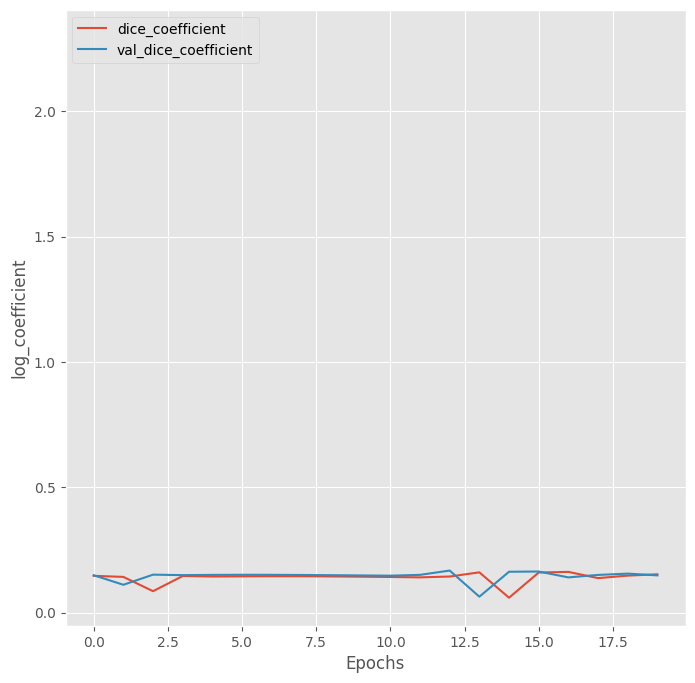

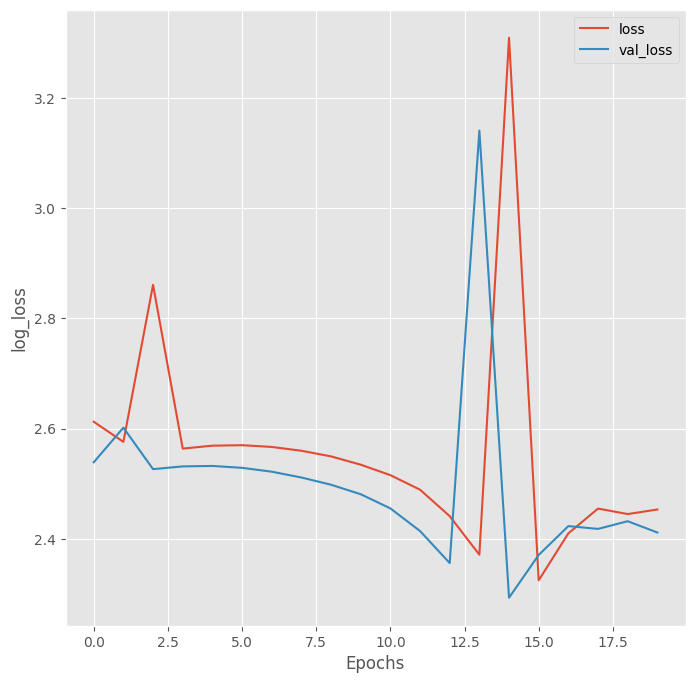

In [ ]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())


def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.math.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

model.compile(optimizer='adam',loss=loss, metrics=[dice_coefficient])
checkpointer = ModelCheckpoint('modelOrgandc.h5', verbose=1, save_best_only=True, save_weights_only=True)
results= model.fit(X_train,y_train,batch_size=32,epochs=20,validation_data=(X_valid, y_valid))

plt.figure(figsize=(8, 8))
#plt.title("Learning curve")
plt.plot(results.history["dice_coefficient"], label="dice_coefficient")
plt.plot(results.history["val_dice_coefficient"], label="val_dice_coefficient")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), color="None" )
plt.xlabel("Epochs")
plt.ylabel("log_coefficient")
plt.legend();

plt.figure(figsize=(8, 8))
#plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), color="None", )
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

model.save_weights('modelOrgandc.h5')
model.load_weights('modelOrgandc.h5')



Epoch 1/20
1/1 [==============================] - 10s 10s/step - loss: 2.4330 - iou_coef: 0.0784 - val_loss: 2.8986 - val_iou_coef: 0.0912
Epoch 2/20
1/1 [==============================] - 3s 3s/step - loss: 3.2184 - iou_coef: 0.0873 - val_loss: 2.3583 - val_iou_coef: 0.0792
Epoch 3/20
1/1 [==============================] - 3s 3s/step - loss: 2.4910 - iou_coef: 0.0799 - val_loss: 2.5157 - val_iou_coef: 0.0598
Epoch 4/20
1/1 [==============================] - 3s 3s/step - loss: 2.3699 - iou_coef: 0.0713 - val_loss: 2.9151 - val_iou_coef: 0.1050
Epoch 5/20
1/1 [==============================] - 5s 5s/step - loss: 4.0621 - iou_coef: 0.1010 - val_loss: 2.3674 - val_iou_coef: 0.0741
Epoch 6/20
1/1 [==============================] - 3s 3s/step - loss: 2.3797 - iou_coef: 0.0729 - val_loss: 2.3713 - val_iou_coef: 0.0826
Epoch 7/20
1/1 [==============================] - 3s 3s/step - loss: 2.4088 - iou_coef: 0.0804 - val_loss: 2.3983 - val_iou_coef: 0.0834
Epoch 8/20
1/1 [=======================

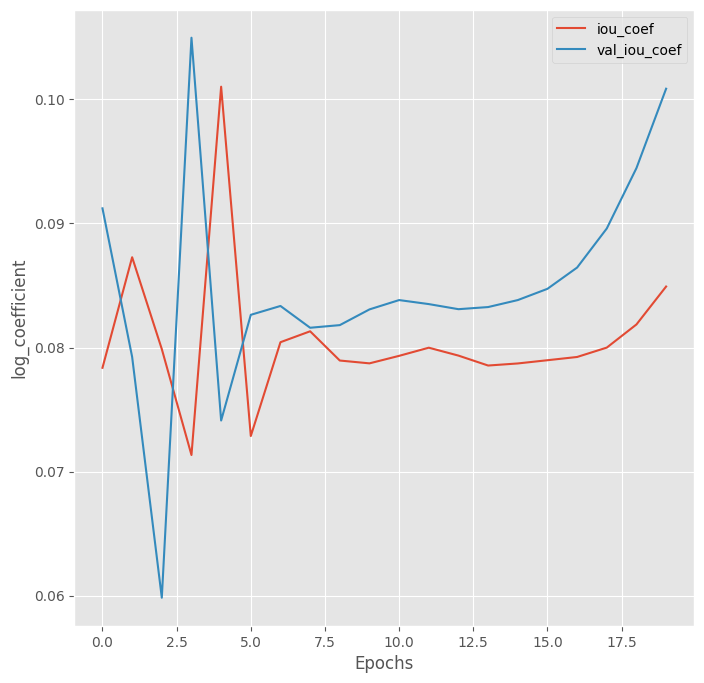

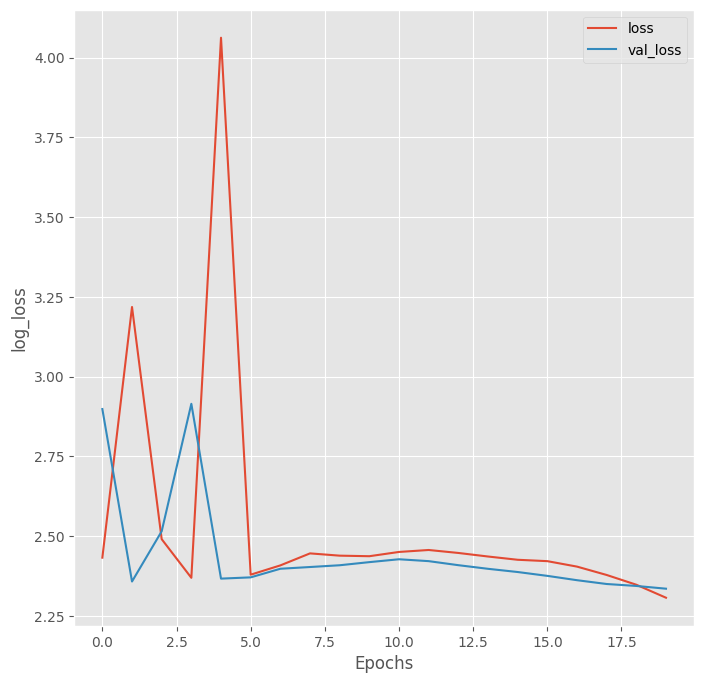

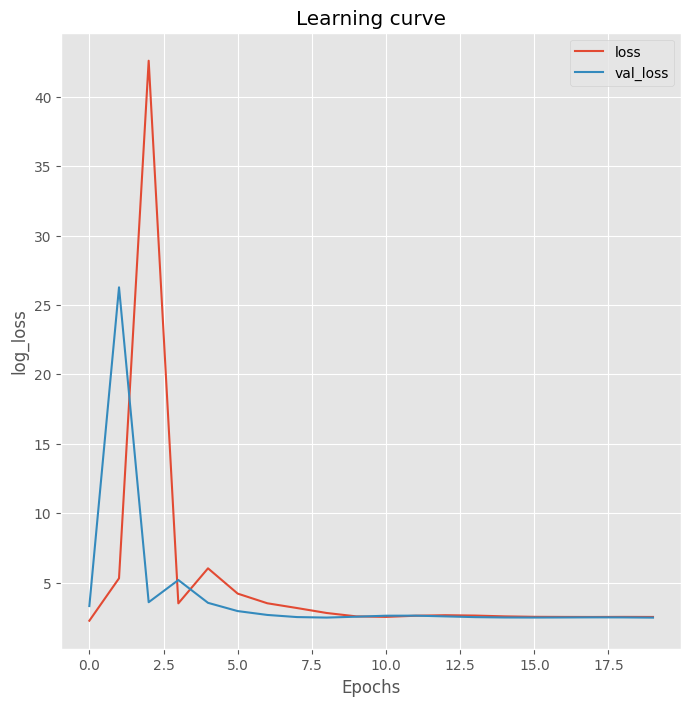

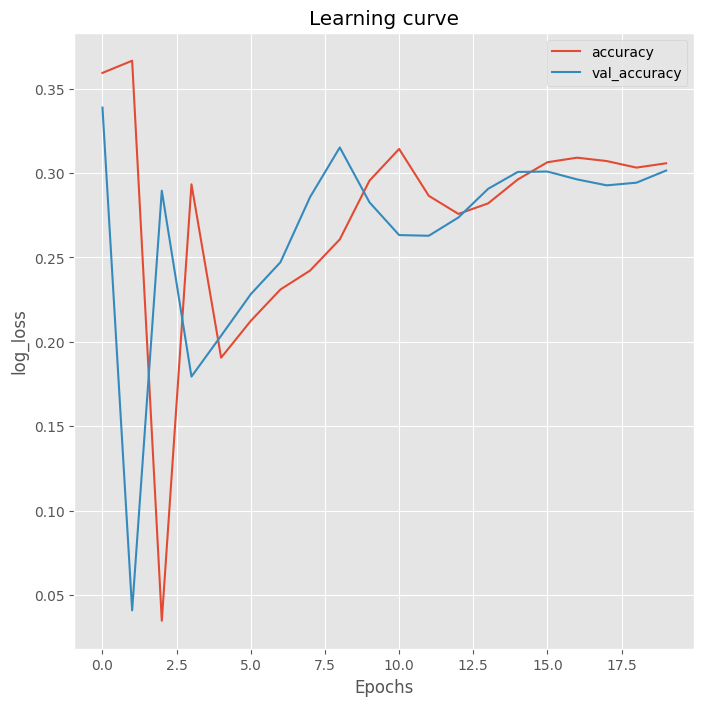

In [ ]:
from keras import backend as K
def iou_coef(preds_train, preds_val, smooth=1):
  intersection = K.sum(K.abs(preds_train * preds_val), axis=[1,2,3])
  union = K.sum(preds_train,[1,2,3])+K.sum(preds_val,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou
  def loss(preds_train, preds_val):
    return binary_crossentropy(preds_train, preds_val) - tf.math.log(iou_coef(preds_train, preds_val) + tf.keras.backend.epsilon())

model.compile(optimizer='Adam', loss=loss, metrics=[iou_coef])
checkpointer = ModelCheckpoint('modelOrgan.h5', verbose=1, save_best_only=True, save_weights_only=True)
results= model.fit(X_train,y_train,batch_size=32,epochs=20,validation_data=(X_valid, y_valid))

plt.figure(figsize=(8, 8))
#plt.title("Learning curve")
plt.plot(results.history["iou_coef"], label="iou_coef")
plt.plot(results.history["val_iou_coef"], label="val_iou_coef")
plt.plot( np.argmin(results.history["val_iou_coef"]), np.min(results.history["val_iou_coef"]), color="None")
plt.xlabel("Epochs")
plt.ylabel("log_coefficient")
plt.legend();

plt.figure(figsize=(8, 8))
#plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), color="None", )
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

model.save_weights('modelOrgan.h5')
model.load_weights('modelOrgan.h5')

model.compile(optimizer='adam',loss=loss, metrics=["accuracy"])
checkpointer = ModelCheckpoint('modelOrgan1.h5', verbose=1, save_best_only=True, save_weights_only=True)
results= model.fit(X_train,y_train,batch_size=32,epochs=20,validation_data=(X_valid, y_valid))

#earlystopper = EarlyStopping(patience=10, verbose=1)
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), color="None", )
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["val_accuracy"], label="val_accuracy")
plt.plot( np.argmin(results.history["val_accuracy"]), np.min(results.history["val_accuracy"]), color="None", )
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

# load the best model
model.save_weights('modelOrgan1.h5')

model.load_weights('modelOrgan1.h5')

model.evaluate(X_valid, y_valid, verbose=1)

#preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

0.162762350876822
0.6573542874580409


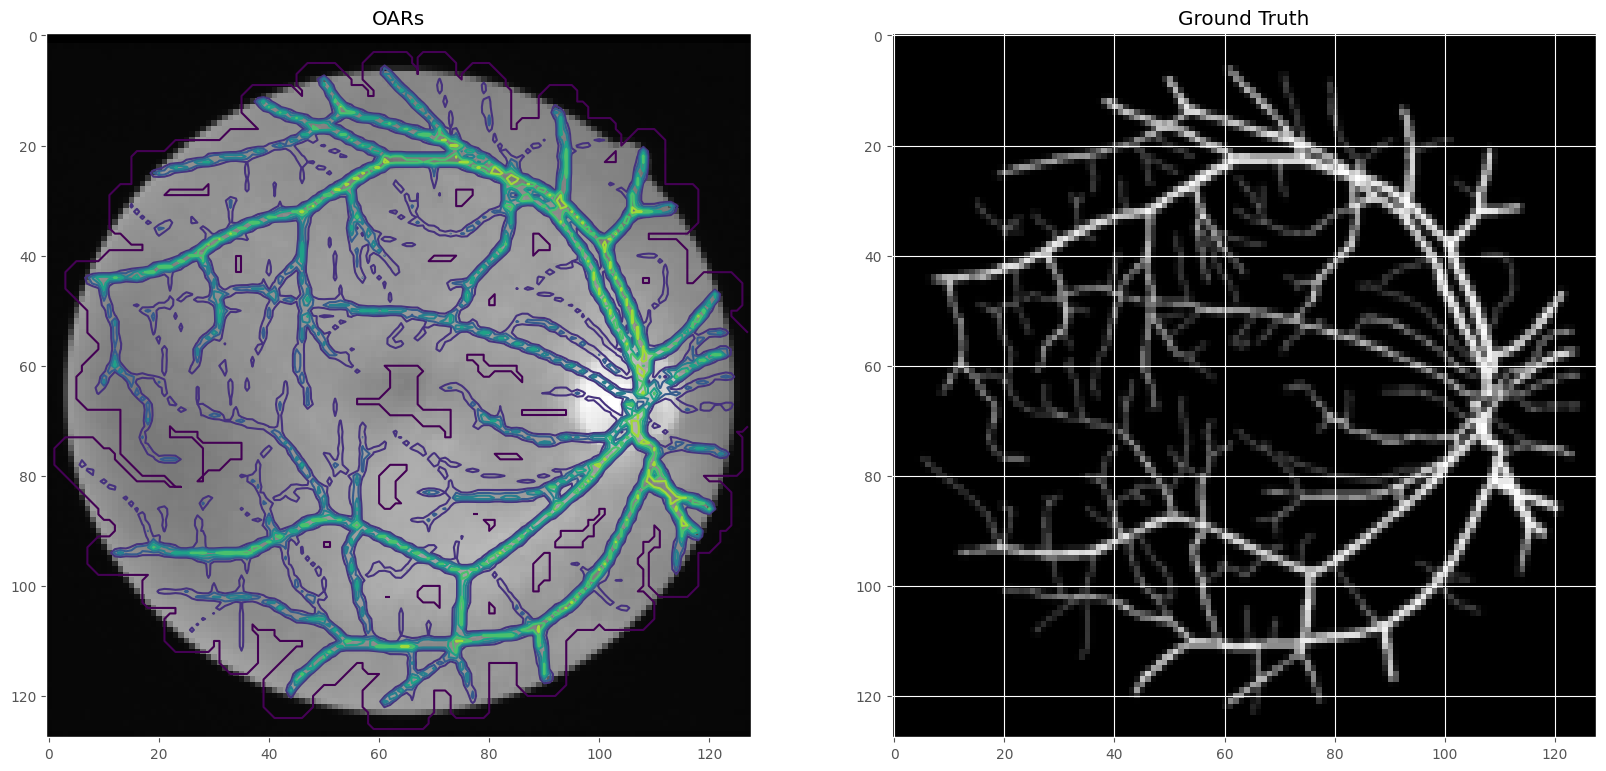

In [ ]:


# #y_v = model.predict_classes(X_valid)
# #print(y_v)

# p=model.predict_proba(X_valid) # to predict probability

# target_names = ['class 0(BIKES)', 'class 1(CARS)', 'class 2(HORSES)']
# print(classification_report(np.argmax(y_valid,axis=1), y_v,target_names=target_names))
# print(confusion_matrix(np.argmax(y_valid,axis=1), y_v))

preds_val

#preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

preds_val_t

def prediction(X_valid, y_valid, preds_val_t, k=None):
    if k  == "None":
        k = np.random.randint(0, len(X_valid))

    has_mask = y_valid[k].max() > 0

    figure, j = plt.subplots(1, 2, figsize=(20, 15))
    j[0].imshow(X_valid[k, ..., 0], cmap='gray')
    j[0].set_title('OARs')
    j[0].grid(None)
    if has_mask:
        j[0].contour(y_valid[k].squeeze())
    T=j[1].imshow(y_valid[k].squeeze(), cmap='gray')
    j[1].set_title('Ground Truth')



prediction(X_valid, y_valid, preds_val_t, k=0)

y_true1=y_valid
y_pred1=preds_val_t

def dice_coef2(y_true1, y_pred1):
    y_true_f = y_true1.flatten()
    y_pred_f = y_pred1.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union==0: return 1
    intersection = np.sum(y_true_f * y_pred_f)
    return 2. * intersection / union

print(dice_coef2(y_true1, y_pred1))

num_classes = y_pred1.shape[-1]

y_pred1 = np.array([ np.argmax(y_pred1, axis=-1)==i
for i in range(num_classes)]).transpose(1,2,3,0)

axes = (1,2) # W,H axes of each image
intersection = np.sum(np.logical_and(y_pred1, y_true1), axis=axes)
# intersection = np.sum(np.abs(y_pred * y_true), axis=axes)
union = np.sum(np.logical_or(y_pred1, y_true1), axis=axes)
mask_sum = np.sum(np.abs(y_true1), axis=axes) + np.sum(np.abs(y_pred1), axis=axes)
# union = mask_sum  - intersection

smooth = 1
iou = (intersection + smooth) / (union + smooth)
iou = np.mean(iou)
print(iou)